<a href="https://colab.research.google.com/github/mhjalili84/Federated-Learning/blob/main/FedAvg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Federated Learning Alpha Analysis



#Import libraries and settings

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

#Settings

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
global_epochs = 10
local_epochs = 5
batch_size = 64
alpha_values = [1, 0.9, 0.7, 0.5, 0.1]
lr = 0.01

#Define model

In [ ]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

#Load and split MNIST dataset

In [ ]:
# Load and split MNIST dataset
transform = transforms.ToTensor()
full_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Split into training and global test set
test_size = int(0.1 * len(full_dataset))
train_size = len(full_dataset) - test_size
train_dataset, global_test_dataset = random_split(full_dataset, [train_size, test_size])

# Split training data into clients
lengths = [int(0.5 * train_size), int(0.3 * train_size), int(0.2 * train_size)]
client_full_datasets = random_split(train_dataset, lengths)

# Further split each client dataset into local train/test
client_train_loaders = []
client_test_loaders = []
for client_dataset in client_full_datasets:
    n_train = int(0.8 * len(client_dataset))
    n_test = len(client_dataset) - n_train
    train_subset, test_subset = random_split(client_dataset, [n_train, n_test])
    client_train_loaders.append(DataLoader(train_subset, batch_size=batch_size, shuffle=True))
    client_test_loaders.append(DataLoader(test_subset, batch_size=batch_size, shuffle=False))

global_test_loader = DataLoader(global_test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 478kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.43MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.84MB/s]


#Define training, evaluation and utility functions

In [ ]:
def get_model_weights(model):
    return [param.data.clone() for param in model.parameters()]

def set_model_weights(model, weights):
    for param, w in zip(model.parameters(), weights):
        param.data = w.clone()

def average_weights(weights_list):
    avg_weights = []
    for weights in zip(*weights_list):
        avg_weights.append(torch.mean(torch.stack(weights), dim=0))
    return avg_weights

def optimal_control_update(avg_weights, local_weights, alpha):
    new_weights = []
    for avg_w, local_w in zip(avg_weights, local_weights):
        new_w = alpha * avg_w + (1 - alpha) * local_w
        new_weights.append(new_w)
    return new_weights

def local_train(model, train_loader, optimizer, criterion):
    model.train()
    for epoch in range(local_epochs):
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            total_loss += loss.item()
            preds = output.argmax(dim=1)
            correct += preds.eq(target).sum().item()
            total += target.size(0)
    avg_loss = total_loss / len(loader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy

def model_distance(model1_weights, model2_weights):
    distance = 0.0
    for w1, w2 in zip(model1_weights, model2_weights):
        distance += torch.norm(w1 - w2).item()
    return distance

#Federated training loop with multiple alphas for iid data distribution

In [ ]:
# Define initial model and save its weights
initial_model = MLP().to(device)
initial_weights = get_model_weights(initial_model)

# Federated learning with different alpha values
results = {}

for alpha in alpha_values:
    print(f"\n===== Training with alpha = {alpha} =====")
    global_model = MLP().to(device)
    set_model_weights(global_model, initial_weights)  # Reset to same initial weights
    global_weights = get_model_weights(global_model)
    criterion = nn.CrossEntropyLoss()

    global_losses = []
    global_accuracies = []
    divergences = []

    for epoch in range(global_epochs):
        print(f"--- Global Epoch {epoch+1} ---")
        local_weights_list = []

        for train_loader in client_train_loaders:
            local_model = MLP().to(device)
            set_model_weights(local_model, global_weights)

            optimizer = optim.SGD(local_model.parameters(), lr=lr)
            local_train(local_model, train_loader, optimizer, criterion)

            local_weights = get_model_weights(local_model)
            local_weights_list.append(local_weights)

        # Average and update
        avg_weights = average_weights(local_weights_list)
        updated_weights_list = [optimal_control_update(avg_weights, lw, alpha) for lw in local_weights_list]
        global_weights = average_weights(updated_weights_list)
        set_model_weights(global_model, global_weights)

        # Evaluate
        global_test_loss, global_test_accuracy = evaluate(global_model, global_test_loader, criterion)
        epoch_divergences = [model_distance(local_w, global_weights) for local_w in local_weights_list]
        avg_divergence = np.mean(epoch_divergences)

        print(f"[Server] Global Test Loss: {global_test_loss:.4f}, Accuracy: {global_test_accuracy:.2f}%, Divergence: {avg_divergence:.4f}")

        global_losses.append(global_test_loss)
        global_accuracies.append(global_test_accuracy)
        divergences.append(avg_divergence)

    results[alpha] = {
        "losses": global_losses,
        "accuracies": global_accuracies,
        "divergences": divergences
    }


===== Training with alpha = 1 =====
--- Global Epoch 1 ---
[Server] Global Test Loss: 0.7974, Accuracy: 81.82%, Divergence: 1.9512
--- Global Epoch 2 ---
[Server] Global Test Loss: 0.4099, Accuracy: 89.17%, Divergence: 0.7751
--- Global Epoch 3 ---
[Server] Global Test Loss: 0.3459, Accuracy: 90.58%, Divergence: 0.6004
--- Global Epoch 4 ---
[Server] Global Test Loss: 0.3170, Accuracy: 90.98%, Divergence: 0.5574
--- Global Epoch 5 ---
[Server] Global Test Loss: 0.2941, Accuracy: 91.63%, Divergence: 0.5414
--- Global Epoch 6 ---
[Server] Global Test Loss: 0.2761, Accuracy: 92.08%, Divergence: 0.5309
--- Global Epoch 7 ---
[Server] Global Test Loss: 0.2601, Accuracy: 92.45%, Divergence: 0.5228
--- Global Epoch 8 ---
[Server] Global Test Loss: 0.2440, Accuracy: 93.02%, Divergence: 0.5150
--- Global Epoch 9 ---
[Server] Global Test Loss: 0.2302, Accuracy: 93.53%, Divergence: 0.5052
--- Global Epoch 10 ---
[Server] Global Test Loss: 0.2173, Accuracy: 93.95%, Divergence: 0.5005

===== Train

#Plot results

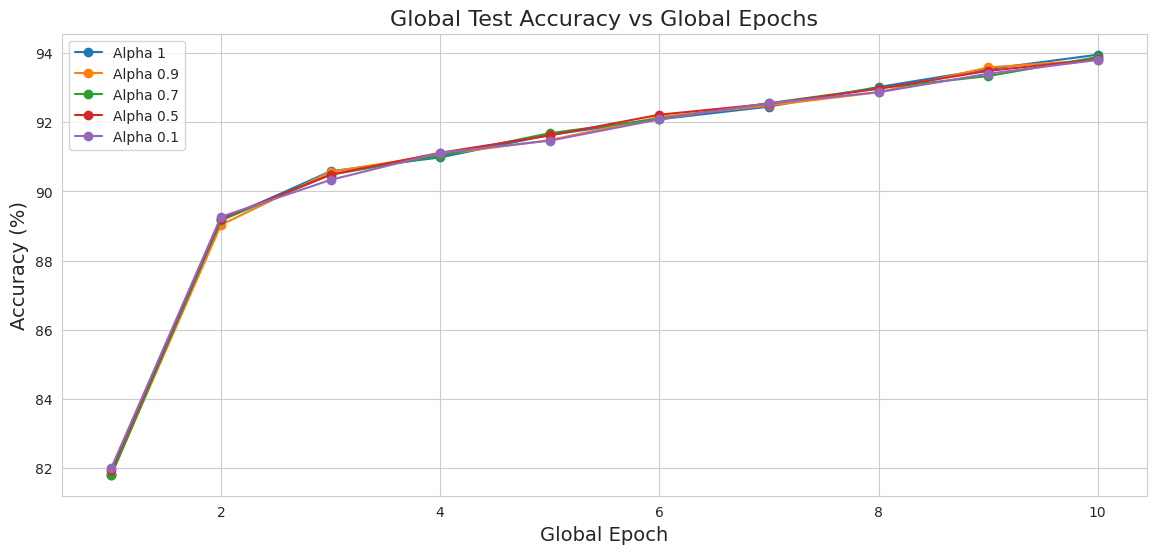

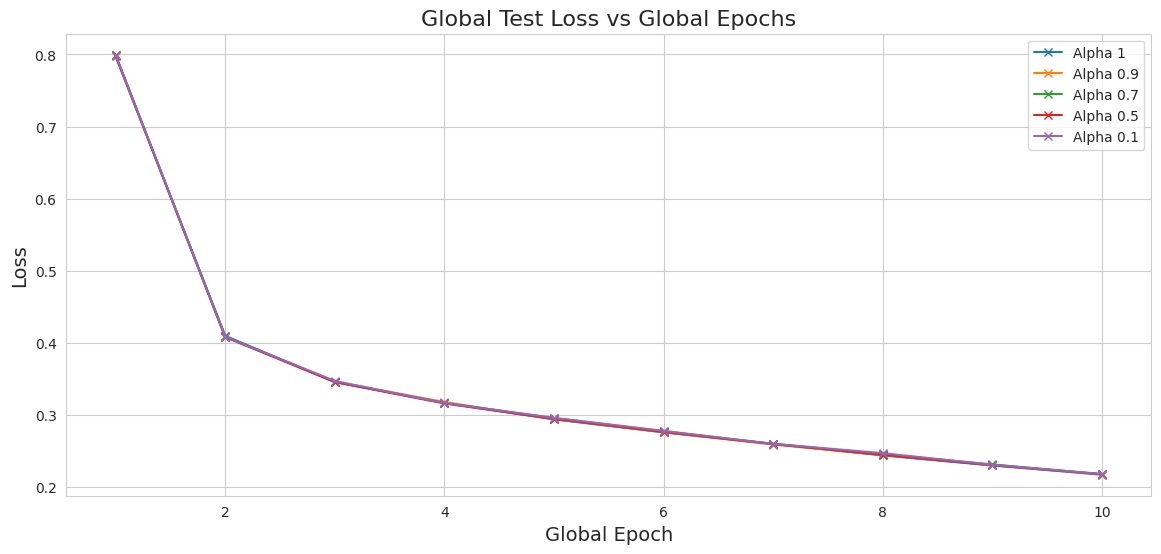

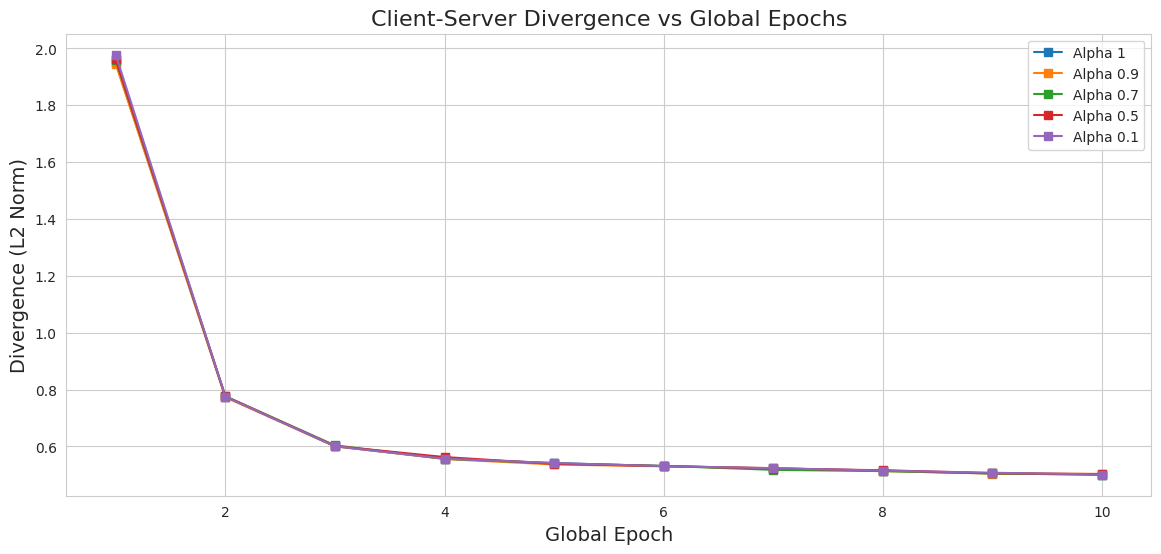


Results saved to 'federated_training_alpha_analysis.csv'.


In [ ]:
#
sns.set_style("whitegrid")
epochs_range = range(1, global_epochs+1)

plt.figure(figsize=(14, 6))
for alpha in alpha_values:
    plt.plot(epochs_range, results[alpha]["accuracies"], marker='o', label=f'Alpha {alpha}')
plt.title('Global Test Accuracy vs Global Epochs', fontsize=16)
plt.xlabel('Global Epoch', fontsize=14)
plt.ylabel('Accuracy (%)', fontsize=14)
plt.legend()
plt.show()

plt.figure(figsize=(14, 6))
for alpha in alpha_values:
    plt.plot(epochs_range, results[alpha]["losses"], marker='x', label=f'Alpha {alpha}')
plt.title('Global Test Loss vs Global Epochs', fontsize=16)
plt.xlabel('Global Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend()
plt.show()

plt.figure(figsize=(14, 6))
for alpha in alpha_values:
    plt.plot(epochs_range, results[alpha]["divergences"], marker='s', label=f'Alpha {alpha}')
plt.title('Client-Server Divergence vs Global Epochs', fontsize=16)
plt.xlabel('Global Epoch', fontsize=14)
plt.ylabel('Divergence (L2 Norm)', fontsize=14)
plt.legend()
plt.show()

# Save results
records = []
for alpha in alpha_values:
    for epoch, (acc, loss, div) in enumerate(zip(results[alpha]["accuracies"], results[alpha]["losses"], results[alpha]["divergences"])):
        records.append({
            "Alpha": alpha,
            "Epoch": epoch + 1,
            "Accuracy": acc,
            "Loss": loss,
            "Divergence": div
        })

results_df = pd.DataFrame(records)
results_df.to_csv("federated_training_alpha_analysis.csv", index=False)
print("\nResults saved to 'federated_training_alpha_analysis.csv'.")



#Federated training loop with multiple alphas for non-iid data distribution

In [ ]:
from collections import defaultdict
import random

# Step 1: Organize indices by class label
label_indices = defaultdict(list)
for idx in range(len(train_dataset)):
    data, label = train_dataset.dataset[train_dataset.indices[idx]]
    label_indices[label].append(idx)

# Step 2: Define classes assigned to each client
client_classes = {
    0: [0, 1, 2, 3],
    1: [4, 5, 6],
    2: [7, 8, 9]
}

# Step 3: Sampling function for clients
def sample_client_data(classes, num_samples):
    indices = []
    samples_per_class = num_samples // len(classes)
    for cls in classes:
        cls_indices = label_indices[cls]
        if samples_per_class > len(cls_indices):
            sampled = random.choices(cls_indices, k=samples_per_class) # oversample if needed
        else:
            sampled = random.sample(cls_indices, samples_per_class)
        indices.extend(sampled)
    return indices

# Step 4: Prepare Non-IID client datasets
client_sizes = [int(0.5 * train_size), int(0.3 * train_size), int(0.2 * train_size)]
client_indices = []

for i in range(3):
    idxs = sample_client_data(client_classes[i], client_sizes[i])
    client_indices.append(idxs)

# Step 5: Create client datasets
client_full_datasets = [Subset(train_dataset, idxs) for idxs in client_indices]

# Step 6: Further split into client train/test sets
client_train_loaders = []
client_test_loaders = []
for client_dataset in client_full_datasets:
    n_train = int(0.8 * len(client_dataset))
    n_test = len(client_dataset) - n_train
    train_subset, test_subset = random_split(client_dataset, [n_train, n_test])
    client_train_loaders.append(DataLoader(train_subset, batch_size=batch_size, shuffle=True))
    client_test_loaders.append(DataLoader(test_subset, batch_size=batch_size, shuffle=False))

In [ ]:
global_epochs = 50
local_epochs = 5

In [ ]:
# Define initial model and save its weights
initial_model = MLP().to(device)
initial_weights = get_model_weights(initial_model)

# Federated learning with different alpha values
results = {}

for alpha in alpha_values:
    print(f"\n===== Training with alpha = {alpha} =====")
    global_model = MLP().to(device)
    set_model_weights(global_model, initial_weights)  # Reset to same initial weights
    global_weights = get_model_weights(global_model)
    criterion = nn.CrossEntropyLoss()

    global_losses = []
    global_accuracies = []
    divergences = []

    for epoch in range(global_epochs):
        print(f"--- Global Epoch {epoch+1} ---")
        local_weights_list = []

        for train_loader in client_train_loaders:
            local_model = MLP().to(device)
            set_model_weights(local_model, global_weights)

            optimizer = optim.SGD(local_model.parameters(), lr=lr)
            local_train(local_model, train_loader, optimizer, criterion)

            local_weights = get_model_weights(local_model)
            local_weights_list.append(local_weights)

        # Average and update
        avg_weights = average_weights(local_weights_list)
        updated_weights_list = [optimal_control_update(avg_weights, lw, alpha) for lw in local_weights_list]
        global_weights = average_weights(updated_weights_list)
        set_model_weights(global_model, global_weights)

        # Evaluate
        global_test_loss, global_test_accuracy = evaluate(global_model, global_test_loader, criterion)
        epoch_divergences = [model_distance(local_w, global_weights) for local_w in local_weights_list]
        avg_divergence = np.mean(epoch_divergences)

        print(f"[Server] Global Test Loss: {global_test_loss:.4f}, Accuracy: {global_test_accuracy:.2f}%, Divergence: {avg_divergence:.4f}")

        global_losses.append(global_test_loss)
        global_accuracies.append(global_test_accuracy)
        divergences.append(avg_divergence)

    results[alpha] = {
        "losses": global_losses,
        "accuracies": global_accuracies,
        "divergences": divergences
    }


===== Training with alpha = 1 =====
--- Global Epoch 1 ---
[Server] Global Test Loss: 1.8961, Accuracy: 55.10%, Divergence: 4.8724
--- Global Epoch 2 ---
[Server] Global Test Loss: 1.3641, Accuracy: 61.30%, Divergence: 3.1956
--- Global Epoch 3 ---
[Server] Global Test Loss: 1.0320, Accuracy: 68.43%, Divergence: 2.4015
--- Global Epoch 4 ---
[Server] Global Test Loss: 0.8688, Accuracy: 71.05%, Divergence: 1.9523
--- Global Epoch 5 ---
[Server] Global Test Loss: 0.7758, Accuracy: 73.40%, Divergence: 1.6882
--- Global Epoch 6 ---
[Server] Global Test Loss: 0.7243, Accuracy: 74.25%, Divergence: 1.5180
--- Global Epoch 7 ---
[Server] Global Test Loss: 0.6854, Accuracy: 75.02%, Divergence: 1.4058
--- Global Epoch 8 ---
[Server] Global Test Loss: 0.6590, Accuracy: 75.95%, Divergence: 1.3222
--- Global Epoch 9 ---
[Server] Global Test Loss: 0.6355, Accuracy: 76.97%, Divergence: 1.2608
--- Global Epoch 10 ---
[Server] Global Test Loss: 0.6136, Accuracy: 77.67%, Divergence: 1.2127
--- Global E